### Import libraries (might not need all of them)

In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import SVG, display
import re, os
from string import printable
import string
from string import punctuation
import pandas as pd
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import json
from tensorflow.python.client import device_lib
from PIL import Image
import copy


import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#py.init_notebook_mode(connected=True)

# For reproducibility
np.random.seed(123)

### Import Keras libraries (Might not need all of them)

In [2]:
import keras
from keras.models import  Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras import backend as K
from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten, Reshape
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers import Input, LSTM, Embedding, BatchNormalization, MaxPooling1D, concatenate, Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Bidirectional, SimpleRNN
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


### Read data, Preprocess

In [3]:
df = pd.read_csv("fake-news-detection\data.csv", sep=',')

In [4]:
df.shape

(4009, 4)

In [5]:
df['Body'].isnull().sum()

21

In [6]:
df = df[pd.notnull(df['Body'])]

In [7]:
df.shape

(3988, 4)

In [8]:
wordnet = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [9]:
def clean_doc(doc, remove_stopwords= True, output_format="string"):
    
    doc = re.sub('_', ' ', doc)
    
    # remove punctuation
    doc = re.sub(r"[\s+\.\!\/_,|%^*#(+\"\')?<>:-]", " ", doc)
    
    # remove @
    pattern2 = r"@\S+"
    doc = re.sub(pattern2, "", doc)
    
    # split into tokens by white space
    tokens = nltk.word_tokenize(doc)
    
    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens]
    
    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words]
    # Return a cleaned string or list
    return" ".join(tokens)

In [10]:
df['CleanBody'] = df['Body'].apply(clean_doc)

In [11]:
list(df)

['URLs', 'Headline', 'Body', 'Label', 'CleanBody']

In [12]:
dist = df.groupby(['Label']).size().reset_index(name='counts')
dist

,Label,counts
0,0,2120
1,1,1868


In [13]:
df1 = df[['CleanBody','Label']]

In [14]:
list(df1)

['CleanBody', 'Label']

In [15]:
df1.shape

(3988, 2)

### Build model using simple LSTM

In [16]:
# Convert raw string in list of lists where characters that are contained in "printable" 
# are stored encoded as integer 
tw_int_tokens = [[printable.index(x) + 1 for x in tweet if x in printable] for tweet in df1.CleanBody]

In [17]:
# Cut tweet string at max_len or pad with zeros if shorter
max_len=10000
X = sequence.pad_sequences(tw_int_tokens, maxlen=max_len)

In [18]:
# Extract labels form df to numpy array
target = np.array(df1.Label)

In [19]:
print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (3988, 10000) Vector dimension of target:  (3988,)


In [20]:
# Simple Cross-Validation: Split the data set into training and test data
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, target, test_size=0.25, random_state=33)

In [21]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [22]:
## Simple LSTM

max_len=10000
emb_dim=32
max_vocab_len=7000
lstm_output_size=32
W_reg=regularizers.l2(1e-4)

# Input
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')

# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                dropout=0.2, W_regularizer=W_reg)(main_input) 

# LSTM layer
lstm = LSTM(lstm_output_size)(emb)
lstm = Dropout(0.5)(lstm)
lstm = Dropout(0.5)(lstm)
        

# Output layer (last fully connected layer)
output = Dense(2, activation='sigmoid', name='output')(lstm)


# Compile model and define optimizer
model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 32)         224000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 232,386
Trainable params: 232,386
Non-trainable params: 0
_________________________________________________________________


In [24]:
batch_size = 100
num_epochs = 100

In [25]:
modelrnn_train = model.fit(x_train, y_train, validation_split=0.25, batch_size=batch_size, epochs=num_epochs)

Train on 2243 samples, validate on 748 samples
Epoch 1/100
2243/2243 [==============================] - 173s 77ms/step - loss: 0.7110 - acc: 0.4920 - val_loss: 0.7093 - val_acc: 0.5214
Epoch 2/100
2243/2243 [==============================] - 222s 99ms/step - loss: 0.7080 - acc: 0.5163 - val_loss: 0.7067 - val_acc: 0.5615
Epoch 3/100
2243/2243 [==============================] - 269s 120ms/step - loss: 0.7057 - acc: 0.5386 - val_loss: 0.7044 - val_acc: 0.5414
Epoch 4/100
2243/2243 [==============================] - 289s 129ms/step - loss: 0.7032 - acc: 0.5410 - val_loss: 0.7023 - val_acc: 0.5414
Epoch 5/100
2243/2243 [==============================] - 301s 134ms/step - loss: 0.7012 - acc: 0.5490 - val_loss: 0.7003 - val_acc: 0.5328
Epoch 6/100
2243/2243 [==============================] - 318s 142ms/step - loss: 0.6996 - acc: 0.5486 - val_loss: 0.6986 - val_acc: 0.5314
Epoch 7/100
2243/2243 [==============================] - 346s 154ms/step - loss: 0.6979 - acc: 0.5481 - val_loss: 0.6970 

2243/2243 [==============================] - 355s 158ms/step - loss: 0.5378 - acc: 0.7570 - val_loss: 0.4925 - val_acc: 0.7834
Epoch 60/100
2243/2243 [==============================] - 360s 160ms/step - loss: 0.5365 - acc: 0.7572 - val_loss: 0.4943 - val_acc: 0.7894
Epoch 61/100
2243/2243 [==============================] - 376s 168ms/step - loss: 0.5350 - acc: 0.7577 - val_loss: 0.4887 - val_acc: 0.7908
Epoch 62/100
2243/2243 [==============================] - 379s 169ms/step - loss: 0.5309 - acc: 0.7628 - val_loss: 0.4869 - val_acc: 0.7928
Epoch 63/100
2243/2243 [==============================] - 378s 168ms/step - loss: 0.5345 - acc: 0.7606 - val_loss: 0.4848 - val_acc: 0.7874
Epoch 64/100
2243/2243 [==============================] - 378s 168ms/step - loss: 0.5272 - acc: 0.7657 - val_loss: 0.4835 - val_acc: 0.7894
Epoch 65/100
2243/2243 [==============================] - 370s 165ms/step - loss: 0.5320 - acc: 0.7633 - val_loss: 0.5265 - val_acc: 0.7767
Epoch 66/100
2243/2243 [=========

### Save model

In [26]:
# Serialize model to JSON
model_digit_json = model.to_json()
with open("model_news_100.json", "w") as json_file:
    json_file.write(model_digit_json)
    
# Serialize weights to HDF5
model.save_weights("model_news_100.h5")
print("Saved model to disk")

Saved model to disk


### Plot model accuracy

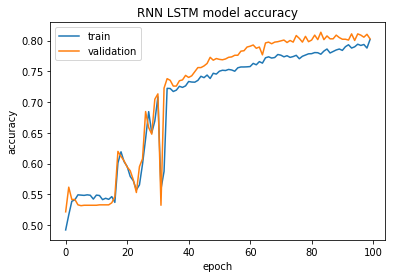

In [27]:
plt.plot(modelrnn_train.history['acc'])
plt.plot(modelrnn_train.history['val_acc'])
plt.title('RNN LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='bottom right')
plt.show()

### Plot model loss

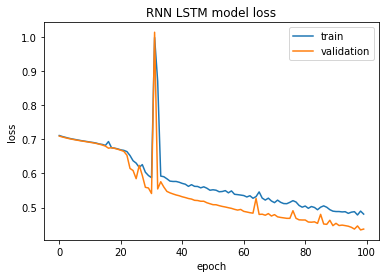

In [28]:
plt.plot(modelrnn_train.history['loss'])
plt.plot(modelrnn_train.history['val_loss'])
plt.title('RNN LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Evaluate model

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("\nTest Accuracy: %.2f%%" % (accuracy*100))

997/997 [==============================] - 19s 19ms/step

Test Accuracy: 80.39%


In [30]:
print('Test Loss: {:0.3f}'.format(loss))

Test Loss: 0.438
